In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/share/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-04-07 13:22:18 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'
2025-04-07 13:22:19 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-04-07 13:22:19 __main__ INFO     transformers.__version__='4.48.2'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig


# model_key = "meta-llama/Llama-3.1-70B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "Qwen/Qwen2-7B"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

mt = ModelandTokenizer(
    model_key=model_key,
    # torch_dtype=torch.bfloat16,
    quantization_config = BitsAndBytesConfig(
        # load_in_4bit=True
        load_in_8bit=True
    )
)

2025-04-07 13:22:31 src.models WARNING  Qwen/Qwen2.5-14B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-04-07 13:22:31 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-04-07 13:22:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/config.json HTTP/1.1" 200 0
2025-04-07 13:22:32 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-04-07 13:22:33 bitsandbytes.cextension DEBUG    Loading bitsandbytes native library from: /share/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda124.so
2025-04-07 13:22:33 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memor

Loading checkpoint shards: 100%|██████████| 8/8 [04:25<00:00, 33.21s/it]

2025-04-07 13:26:59 urllib3.connectionpool DEBUG    Resetting dropped connection: huggingface.co


2025-04-07 13:27:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-04-07 13:27:00 src.models INFO     loaded model <Qwen/Qwen2.5-14B> | size: 15571.604 MB | dtype: torch.float16 | device: cuda:0


In [4]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-04-07 13:27:18 __main__ INFO     len(coincidences['examples'])=13
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['jellyfish', 'lobster'] <-- salmon
11 => ['crocodile', 'shark'] <-- salmon
12 => ['spider', 'crab'] <-- lobster


In [7]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = coincidences["examples"][0]["entity_pair"]
# entities = ("Whale", "Dolphin")
# entities = ("Nautilus", "Dolphin")
# entities = ("Abraham Lincoln", "John F. Kennedy")
# entities = ("Brad Pitt", "Angelina Jolie")
# entities = ("Emu", "Ostrich")
# entities = ("Elephant", "Whale")
# entities = ("Wolverine", "Penguin")
# entities = ("Giraffe", "Reindeer")
entities = coincidences["examples"][5]["entity_pair"]

print(entities)

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

['Leonardo da Vinci', 'Benjamin Franklin']
Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Leonardo da Vinci and Benjamin Frankli

In [8]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

['Leonardo da Vinci', 'Benjamin Franklin']


[[PredictedToken(token=' polym', prob=0.473388671875, logit=19.671875, token_id=44933),
  PredictedToken(token=' invent', prob=0.091796875, logit=18.03125, token_id=17023),
  PredictedToken(token=' artists', prob=0.056549072265625, logit=17.546875, token_id=13511),
  PredictedToken(token=' Renaissance', prob=0.046875, logit=17.359375, token_id=54283),
  PredictedToken(token=' famous', prob=0.044036865234375, logit=17.296875, token_id=11245)]]

In [9]:
# single_probing_prompt = "Who/what is {}? Answer: {} is a"

# pred, track_ans = predict_next_token(
#     mt = mt,
#     inputs = [single_probing_prompt.format(entities[0], entities[0])],
#     k=15,
#     token_of_interest=[clean_pred[0][0].token_id]
# )

# print(track_ans)
# pred

In [10]:
# pred, track_ans = predict_next_token(
#     mt = mt,
#     inputs = single_probing_prompt.format(entities[1], entities[1]),
#     k=15,
#     token_of_interest=[clean_pred[0][0].token_id]
# )

# print(track_ans)
# pred

## Ablating the heads to check their importance

In [11]:
import types
from tqdm.auto import tqdm
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token, get_module_nnsight, interpret_logits
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
from src.utils.typing import PredictedToken

def get_edges_to_be_ablated(
    prompt: ProbingPrompt,
    focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all",
    Q_IDX: int = -1, # almost always the last token position
    whitelist_key_indices: list[int] = [0, -1]
):
    for idx, ti in enumerate(whitelist_key_indices):
        if ti < 0:
            whitelist_key_indices[idx] = prompt.tokenized["input_ids"][0].shape[-1] + ti
    
    if focus_strategy == "entities":
        whitelist_key_indices += list(range(*prompt.entity_ranges[0])) + list(range(*prompt.entity_ranges[1]))
    elif focus_strategy == "entities_last":
        whitelist_key_indices += [prompt.entity_ranges[0][1] - 1, prompt.entity_ranges[1][1] - 1]
    elif focus_strategy == "ablate_all":
        pass
    else:
        raise ValueError(f"{focus_strategy=}")
    
    whitelist_key_indices = list(set(whitelist_key_indices))
    if Q_IDX < 0:
        Q_IDX = prompt.tokenized["input_ids"][0].shape[-1] + Q_IDX
    
    block_edges: list[AttentionEdge] = []
    for k_idx in range(1, prompt.tokenized["input_ids"][0].shape[-1]):
        if k_idx in whitelist_key_indices:
            continue
        block_edges.append(
            AttentionEdge(
                q_idx=Q_IDX,
                k_idx=k_idx,
            )
        )
    
    return block_edges

    

@torch.inference_mode()
def attn_blocking_sweep_cumulative(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    direction: Literal["asc", "desc"] = "asc",
    step: int = 1,
    verbose: bool = False
):
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()
    
    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    effects = {}

    if direction == "asc":
        progress = tqdm(range(0, mt.n_layer, step))
    elif direction == "desc":
        progress = tqdm(range(mt.n_layer - 1, -1, -step))

    progress.set_description(f"{direction=}")

    for layer_idx in progress:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        # attn_block = get_module_nnsight(mt, attn_block_name)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

        ablated_pred, track_ans = predict_next_token(
            mt=mt, 
            inputs=inputs,
            token_of_interest=[clean_answer.token_id]
        )
        # output = mt._model(**inputs)
        # logits = output.logits[:, -1, :].squeeze()
        # ablated_pred, track_ans = interpret_logits(tokenizer=mt, logits=logits, interested_tokens=[answer.token_id])

        if verbose:
            logger.debug(f"{layer_idx}: {track_ans=}")

        effects[layer_idx] = {
            "track_ans": track_ans,
            "ablated_pred": ablated_pred,
        }
    

    mt.reset_forward()
    return effects

# block_edges = get_edges_to_be_ablated(
#     prompt=prompt,
#     focus_strategy="entities",
#     Q_IDX=-1,
#     whitelist_key_indices=[0, -1]
# )

# blocking_effects = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     block_edges=block_edges,
#     clean_answer=clean_pred[0][0],
#     direction="desc",
# )

In [12]:
# focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# block_edges = get_edges_to_be_ablated(
#     prompt=prompt,
#     focus_strategy=focus_strategy,
#     Q_IDX=-1,
#     whitelist_key_indices=[0, -1]
# )

# effects_asc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="asc",
# )
# effects_desc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="desc",
# )    

In [13]:
# clean_pred[0][0]

In [14]:
# import matplotlib.pyplot as plt

# metric = "prob"

# denom = getattr(clean_pred[0][0], metric)

# layers = list(range(mt.n_layer))
# values_asc = []
# for layer_idx in layers:
#     track_ans = list(effects_asc[layer_idx]["track_ans"][0].values())[0][1]
#     values_asc.append(getattr(track_ans, metric) / denom)

# values_desc = []
# for layer_idx in layers:
#     track_ans = list(effects_desc[layer_idx]["track_ans"][0].values())[0][1]
#     values_desc.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.title(f"ATTN Ablation Effects ({metric}) | {focus_strategy}")

# plt.plot(values_asc, marker="o", label="asc")
# plt.plot(values_desc, marker="o", label="desc")

# plt.xticks(layers)
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.legend()

# plt.show()

In [15]:
@torch.inference_mode()
def ablate_attn_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    layer_window: list[int],
    k = 5,
    debug_full_answer = False
):
    
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    for layer_idx in layer_window:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

    if debug_full_answer:
        answer = get_lm_generated_answer(
            mt=mt, prompt=prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower(),
            use_kv_cache=False
        )
        print(f"{answer=}")

    ablated_pred, track_ans = predict_next_token(
        mt=mt, 
        inputs=inputs,
        token_of_interest=[clean_answer.token_id],
        k=k
    )

    mt.reset_forward()

    return ablated_pred, track_ans

In [14]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# layer_window = list(range(0, 5))
# layer_window = list(range(0, mt.n_layer))
# layer_window = list(range(10, 20))
layer_window = list(range(20, 45)) #! critical layers! "ablate_all" works. but "entities" does not work

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy=focus_strategy,
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

track_ans = ablate_attn_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=layer_window,
    debug_full_answer=True,
)

track_ans

answer='mammals.'


([[PredictedToken(token=' mammals', prob=0.0322265625, logit=14.0625, token_id=55569),
   PredictedToken(token=' very', prob=0.0302734375, logit=14.0, token_id=1602),
   PredictedToken(token=' in', prob=0.020751953125, logit=13.625, token_id=304),
   PredictedToken(token=' created', prob=0.018310546875, logit=13.5, token_id=3465),
   PredictedToken(token=' animals', prob=0.0172119140625, logit=13.4375, token_id=9898)]],
 [{71527: (144,
    PredictedToken(token=' apex', prob=0.0010986328125, logit=10.6875, token_id=71527))}])

In [15]:
from src.trace import get_window

def attn_blocking_sweep_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    window_size: int,
):
    effects = {}

    for layer_idx in tqdm(range(mt.n_layer), desc=f"{window_size=}"):
        layer_window = get_window("{}", layer_idx, window_size, mt.n_layer)
        layer_window = [int(l) for l in layer_window]
        ablated_pred, track_ans = ablate_attn_window(
            mt=mt,
            prompt=prompt,
            clean_answer=clean_answer,
            block_edges=block_edges,
            layer_window=layer_window,
        )
        effects[layer_idx] = dict(
            track_ans=track_ans,
            ablated_pred=ablated_pred,
        )
    return effects  

window_ablation_effects = attn_blocking_sweep_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    window_size=11,
)

window_size=11: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


In [17]:
# window_ablation_effects

In [18]:
# from matplotlib import pyplot as plt

# metric = "prob"
# denom = getattr(clean_pred[0][0], metric)

# values = []
# layers = list(range(mt.n_layer))
# for layer_idx in layers:
#     track_ans = list(window_ablation_effects[layer_idx]["track_ans"][0].values())[0][1]
#     values.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.plot(values, marker="o")
# plt.xticks(layers)

# plt.title(f"Ablate ATTN sweep (window size={5})")
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.ylim(bottom=0)  
# plt.legend()

In [19]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-19 10:47:42 __main__ INFO     len(coincidences['examples'])=20


In [28]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "entities"

effects = []

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    prompt = prepare_probing_input(
        mt=mt,
        entities=entities,
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both"
    )

    clean_answer = predict_next_token(mt=mt, inputs = TokenizerOutput(data = prompt.tokenized), k=1)[0][0]
    logger.info(f"{clean_answer=}")

    block_edges = get_edges_to_be_ablated(
        prompt=prompt,
        focus_strategy=focus_strategy,
        Q_IDX=-2,
        whitelist_key_indices=[0]
        # whitelist_key_indices=[0, -1]
    )

    cumulative_effects_asc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="asc",
    )

    cumulative_effects_desc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="desc",
    )

    attn_ablation_effects = attn_blocking_sweep_window(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        window_size=5,
    )


    effects.append(dict(
        entities=entities,
        clean_answer=clean_answer,
        attn_ablation_effects=attn_ablation_effects,
        cumulative_effects=dict(
            asc=cumulative_effects_asc,
            desc=cumulative_effects_desc
        )
    ))

    print("-" * 80)

2025-02-19 11:17:53 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


2025-02-19 11:17:53 __main__ INFO     clean_answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:19:09 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']


2025-02-19 11:19:09 __main__ INFO     clean_answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]

--------------------------------------------------------------------------------
2025-02-19 11:20:24 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']


2025-02-19 11:20:25 __main__ INFO     clean_answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:21:41 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']


2025-02-19 11:21:41 __main__ INFO     clean_answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:22:55 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']


2025-02-19 11:22:56 __main__ INFO     clean_answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]

--------------------------------------------------------------------------------
2025-02-19 11:24:10 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']


2025-02-19 11:24:10 __main__ INFO     clean_answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:25:26 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']


2025-02-19 11:25:26 __main__ INFO     clean_answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]

--------------------------------------------------------------------------------
2025-02-19 11:26:42 __main__ INFO     (8/20)  entities=['Memento', 'Inception']


2025-02-19 11:26:42 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------
2025-02-19 11:27:57 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']


2025-02-19 11:27:58 __main__ INFO     clean_answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]

--------------------------------------------------------------------------------
2025-02-19 11:29:14 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']


2025-02-19 11:29:14 __main__ INFO     clean_answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:30:31 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']


2025-02-19 11:30:31 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:31:48 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']


2025-02-19 11:31:48 __main__ INFO     clean_answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]

--------------------------------------------------------------------------------
2025-02-19 11:33:08 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']


2025-02-19 11:33:09 __main__ INFO     clean_answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

--------------------------------------------------------------------------------
2025-02-19 11:34:33 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']


2025-02-19 11:34:34 __main__ INFO     clean_answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]

--------------------------------------------------------------------------------
2025-02-19 11:35:52 __main__ INFO     (15/20)  entities=['Brazil', 'Turkey']


2025-02-19 11:35:52 __main__ INFO     clean_answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:37:08 __main__ INFO     (16/20)  entities=['jellyfish', 'lobster']


2025-02-19 11:37:08 __main__ INFO     clean_answer=PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:38:23 __main__ INFO     (17/20)  entities=['corn', 'wheat']


2025-02-19 11:38:23 __main__ INFO     clean_answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:39:39 __main__ INFO     (18/20)  entities=['crocodile', 'shark']


2025-02-19 11:39:39 __main__ INFO     clean_answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:40:55 __main__ INFO     (19/20)  entities=['crab', 'spider']


2025-02-19 11:40:56 __main__ INFO     clean_answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]

--------------------------------------------------------------------------------
2025-02-19 11:42:12 __main__ INFO     (20/20)  entities=['copper', 'gold']


2025-02-19 11:42:12 __main__ INFO     clean_answer=PredictedToken(token=' used', prob=0.4423828125, logit=18.171875, token_id=1511)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------


In [31]:
def get_metric_value(track_ans, metric):
    rank, pred = list(track_ans[0].values())[0]
    if metric in ["prob", "logit"]:
        return getattr(pred, metric)
    elif metric == "reciprocal_rank":
        return 1 / rank

from src.utils.metrics import AggregateMetric
from typing import Optional
def process_effects_per_layer(
    effects: list[dict],
    metric: Literal["logit", "prob", "reciprocal_rank"] = "prob",
    v_clean_ans: Optional[list[float]] = None
):
    if v_clean_ans is not None:
        assert metric in ["logit", "prob"]
        assert len(v_clean_ans) == len(effects)

    layer_wise_results: dict[int, AggregateMetric] = {}
    layer_indices = list(range(mt.n_layer))
    for layer_idx in layer_indices:
        values = []
        for idx, e in enumerate(effects):
            track_ans = e[int(layer_idx)]["track_ans"]
            v = get_metric_value(track_ans, metric)
            if v_clean_ans is not None:
                v /= v_clean_ans[idx]
            values.append(v)
        layer_wise_results[layer_idx] = AggregateMetric.aggregate(values)
    return layer_wise_results


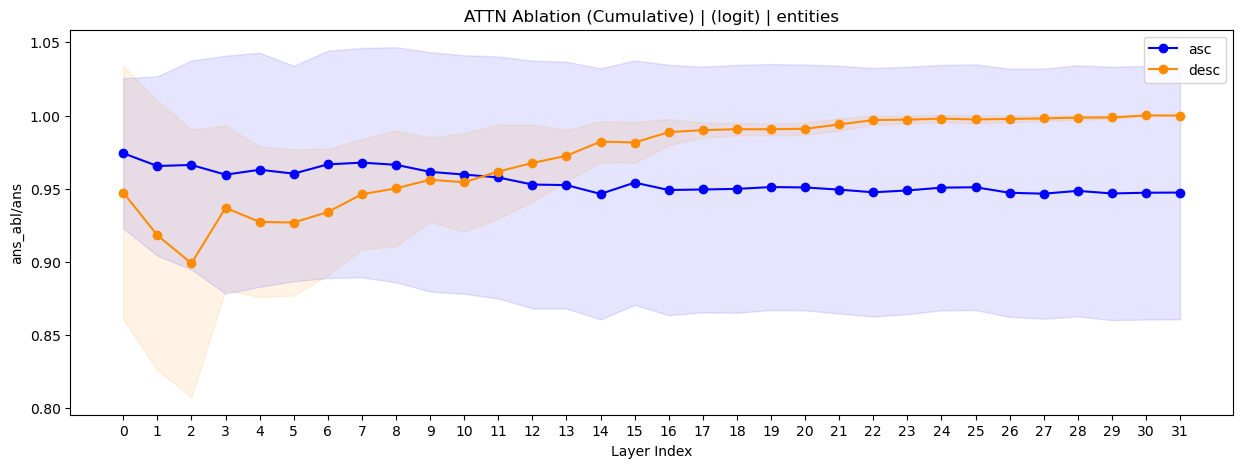

In [36]:
from matplotlib import pyplot as plt

metric: Literal["logit", "prob", "reciprocal_rank"] = "logit"

effects_asc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["asc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)


effects_desc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["desc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

def plot_metric(results: dict[int, AggregateMetric], keys: list, label: str, color:str, canvas=plt):
    values = [results[k].mean for k in keys]
    stds = [results[k].stdev for k in keys]
    canvas.plot(values, marker="o", label=label, color=color)
    canvas.fill_between(keys, [v - s for v, s in zip(values, stds)], [v + s for v, s in zip(values, stds)], alpha=0.1, color=color)


plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (Cumulative) | ({metric}) | {focus_strategy}")

layers = list(range(mt.n_layer))
plot_metric(effects_asc, layers, "asc", color="blue")
plot_metric(effects_desc, layers, "desc", color="darkorange")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

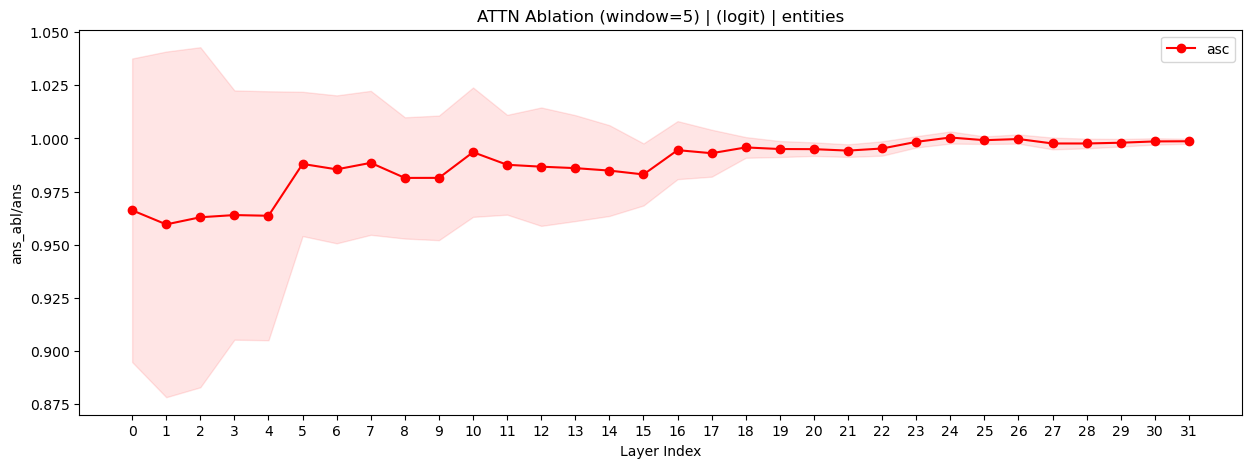

In [37]:
effects_window = process_effects_per_layer(
    effects=[e["attn_ablation_effects"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (window=5) | ({metric}) | {focus_strategy}")

plot_metric(effects_window, list(effects_asc.keys()), "asc", color="red")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

## Patching from a different run to check contribution

In [17]:
sample_idx = 5
sample = coincidences["examples"][sample_idx]
sample

{'entity_pair': ['Leonardo da Vinci', 'Benjamin Franklin'],
 'connection': 'polymaths.',
 'alt_first': {'entity': 'George Washington',
  'connection': 'American Founding Fathers.'}}

In [18]:
patch_prompt = prepare_probing_input(
    mt=mt,
    entities=sample["entity_pair"],
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)


answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["entity_pair"]} >> {answer=}')

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
)

clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'


In [19]:
from src.functional import get_keywords

keywords = get_keywords(text = answer, tokenizer=mt)
keywords

[44933]

In [20]:
from src.functional import get_hs
from src.trace import calculate_indirect_effects

patch_attn_outputs = get_hs(
    mt = mt,
    input = patch_prompt.prompt,
    locations = [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True
)

In [21]:
# from src.utils.typing import TokenizerOutput

# ie = calculate_indirect_effects(
#     mt = mt,
#     locations = [(30, -1)],
#     corrupted_input = TokenizerOutput(data = clean_prompt.tokenized),
#     patch_states = patch_attn_outputs,
#     patch_ans_t=keywords,
#     layer_name_format=mt.attn_module_name_format,
#     window_size=11,
#     metric = "logit" 
# )

# ie

In [30]:
from src.functional import PatchSpec, generate_with_patch, interpret_logits
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal

@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt = mt,
            inputs = inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches = patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False, # don't need to

            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f"\"{answer[0]}\"")
    
    logits = get_hs(
        mt = mt,
        input = inputs,
        locations = [(mt.lm_head_name, -1)],
        patches = patches,
        return_dict=False
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=ans_tokens,
        **next_tok_kwargs
    )

    score = get_score(logits = logits, token_id=ans_tokens, metric = metric)

    return score, pred, track


patch_attn_outputs = get_hs(
    mt = mt,
    input = patch_prompt.prompt,
    locations = [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True
)

# layer_idx = 30
# layer_window = get_window(mt.attn_module_name_format, layer_idx, 5, mt.n_layer)
layer_window = range(28, 35)
# layer_window = range(10, 20)
# layer_window = range(40, mt.n_layer-2)

gold_score, gold_pred, gold_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = patch_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = "logit",
)
print(f"{gold_score=}")

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = clean_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = "logit",
)
print(f"{corrupt_score=}")



layer_window = [mt.attn_module_name_format.format(l) for l in layer_window]
input = TokenizerOutput(data = clean_prompt.tokenized)
last_tok_idx = input.input_ids.shape[1] - 1

patches = [
    PatchSpec(
        location = (layer, last_tok_idx),
        patch = 2 * patch_attn_outputs[(layer, -1)]
    ) for layer in layer_window
]
# patches = []

patched_score, pred, track = patched_run(
    mt = mt,
    inputs = input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = True,
    metric = "logit",
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

gold_score=19.671875
corrupt_score=11.703125
" polymaths.
#
Q: The White House and The Pentagon
A: They are both government buildings"
patched_score=18.234375
pred=[PredictedToken(token=' polym', prob=0.219970703125, logit=18.234375, token_id=44933), PredictedToken(token=' famous', prob=0.13134765625, logit=17.71875, token_id=11245), PredictedToken(token=' invent', prob=0.0875244140625, logit=17.3125, token_id=17023), PredictedToken(token=' American', prob=0.07843017578125, logit=17.203125, token_id=3693), PredictedToken(token=' Renaissance', prob=0.03271484375, logit=16.328125, token_id=54283)]
track={44933: (1, PredictedToken(token=' polym', prob=0.219970703125, logit=18.234375, token_id=44933))}


In [76]:
from src.functional import get_keywords
from src.trace import get_window
from typing import Optional

@torch.inference_mode()
def do_patching_sweep(
    mt: ModelandTokenizer,
    samples: list[dict],
    layers: Optional[list[int]] = None,
    token_idx = -1, #TODO: incorporate different key positions like: subj_last, token_last, all_subj, ...
    metric: Literal["logit", "prob"] = "logit",
    coeff: float = 1.0,
    kind: Literal["mlp", "attn", "residual"] = "attn",
    window: int | Literal["from", "upto"] = 5,
) -> dict:
    layers = list(range(mt.n_layer)) if layers is None else layers
    module_name_format = {
        "residual": mt.layer_name_format,
        "mlp": mt.mlp_module_name_format,
        "attn": mt.attn_module_name_format,
    }[kind]

    results = []
    for idx, sample in tqdm(enumerate(samples)):
        logger.info(f"({idx+1}/{len(samples)})  {sample['entity_pair']=} <-- {sample['alt_first']['entity']}")
        patch_prompt = prepare_probing_input(
            mt=mt,
            entities=sample["entity_pair"],
            prefix=prefix,
            answer_marker=answer_marker,
            question_marker=question_marker,
            block_separator=block_separator,
            is_a_reasoning_model="deepseek" in model_key.lower(),
            answer_prefix=" They are/were both"
        )
        answer = get_lm_generated_answer(
            mt=mt, prompt=prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower()
        )
        logger.info(f'{sample["entity_pair"]} >> {answer=}')

        clean_prompt = prepare_probing_input(
            mt=mt,
            entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
            prefix=prefix,
            answer_marker=answer_marker,
            question_marker=question_marker,
            block_separator=block_separator,
            is_a_reasoning_model="deepseek" in model_key.lower(),
            answer_prefix=" They are/were both"
        )

        clean_answer = get_lm_generated_answer(
            mt=mt, prompt=clean_prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower()
        )
        logger.info(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

        answer_tokens = get_keywords(text = answer, tokenizer=mt)
        logger.info(f'{[f"{t}({mt.tokenizer.decode(t)})" for t in answer_tokens]}')


        gold_score, gold_pred, gold_track = patched_run(
            mt = mt,
            inputs = TokenizerOutput(data = patch_prompt.tokenized),
            patches = [],
            ans_tokens = answer_tokens,
            metric=metric
        )
        logger.info(f"{gold_score=}")

        corrupt_score, corrupt_pred, corrupt_track = patched_run(
            mt = mt,
            inputs = TokenizerOutput(data = clean_prompt.tokenized),
            patches = [],
            ans_tokens = answer_tokens,
            metric=metric
        )
        logger.info(f"{corrupt_score=}")
        

        patch_layers = {}
        unique_layers = []
        for layer_idx in layers:
            if window == "from":
                layer_window = range(layer_idx, mt.n_layer)
            elif window == "upto":
                layer_window = range(0, layer_idx + 1)
            else:
                assert isinstance(window, int)
                layer_window = [int(l) for l in get_window("{}", layer_idx, window, mt.n_layer)]
            
            patch_layers[layer_idx] = [module_name_format.format(l) for l in layer_window]
            unique_layers += patch_layers[layer_idx]

        unique_layers = set(unique_layers)

        patch_outputs = get_hs(
            mt = mt,
            input = patch_prompt.prompt,
            locations = [(l, token_idx) for l in unique_layers],
            return_dict = True
        )

        patching_results = {}
        clean_input = TokenizerOutput(data = clean_prompt.tokenized)

        #! currently assumes `token_idx to cache state from LM(patch_input) == token_idx to patch to LM(clean_input)` (change?)
        patch_token_idx = token_idx
        if patch_token_idx < 0:
            patch_token_idx = clean_input.input_ids.shape[1] + token_idx

        for layer_idx, layer_window in patch_layers.items():

            patches = [
                PatchSpec(
                    location = (layer, patch_token_idx),
                    patch = coeff * patch_outputs[(layer, token_idx)]
                ) for layer in layer_window
            ]

            patched_score, pred, track = patched_run(
                mt = mt,
                inputs = clean_input,
                patches = patches,
                ans_tokens = answer_tokens,
                generate_full_ans = False,
                metric = metric
            )

            logger.debug(f"         {layer_idx=}, {patched_score=}")
            # print(layer_window)

            patching_results[layer_idx] = dict(
                score=patched_score,
                pred=pred,
                track=track,
            )
        
        logger.debug("-"*30)
        
        results.append(dict(
            sample = sample,
            answer = answer,
            answer_tokens = answer_tokens,
            gold_score = gold_score,
            corrupt_score = corrupt_score,
            patching_results = patching_results,
        ))

    return results
            

kwargs = dict(
    mt = mt,
    samples = [coincidences["examples"][sample_idx]],
    token_idx = -1,
    metric = "logit",
    coeff = 2.0,
    kind = "attn",
)

res_from = do_patching_sweep(
    **kwargs,
    window = "from",
)

res_upto = do_patching_sweep(
    **kwargs,
    window = "upto",
)

res_win = do_patching_sweep(
    **kwargs,
    window = 5,
)

0it [00:00, ?it/s]

2025-04-07 14:59:57 __main__ INFO     (1/1)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington


2025-04-07 15:00:02 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 15:00:08 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 15:00:08 __main__ INFO     ['44933( polym)']
2025-04-07 15:00:08 __main__ INFO     gold_score=19.671875
2025-04-07 15:00:08 __main__ INFO     corrupt_score=11.703125
2025-04-07 15:00:08 __main__ DEBUG             layer_idx=0, patched_score=16.265625
2025-04-07 15:00:09 __main__ DEBUG             layer_idx=1, patched_score=16.53125
2025-04-07 15:00:09 __main__ DEBUG             layer_idx=2, patched_score=16.53125
2025-04-07 15:00:09 __main__ DEBUG             layer_idx=3, patched_score=16.625
2025-04-07 15:00:09 __main__ DEBUG             layer_idx=4, patched_score=16.671875
2025-04-07 15:00:09 __main__ DEBUG             layer_idx=5, patched_score=16.5625
2025-04-07 15:00:10 __main__ DEBUG             layer_idx=6, patched_score=16.578125
2025-04-07 15:00:

1it [00:20, 20.42s/it]
0it [00:00, ?it/s]

2025-04-07 15:00:17 __main__ INFO     (1/1)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 15:00:23 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 15:00:28 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 15:00:28 __main__ INFO     ['44933( polym)']
2025-04-07 15:00:29 __main__ INFO     gold_score=19.671875
2025-04-07 15:00:29 __main__ INFO     corrupt_score=11.703125
2025-04-07 15:00:29 __main__ DEBUG             layer_idx=0, patched_score=11.2265625
2025-04-07 15:00:29 __main__ DEBUG             layer_idx=1, patched_score=11.359375
2025-04-07 15:00:29 __main__ DEBUG             layer_idx=2, patched_score=11.375
2025-04-07 15:00:30 __main__ DEBUG             layer_idx=3, patched_score=11.421875
2025-04-07 15:00:30 __main__ DEBUG             layer_idx=4, patched_score=11.46875
2025-04-07 15:00:30 __main__ DEBUG             la

1it [00:20, 20.54s/it]
0it [00:00, ?it/s]

2025-04-07 15:00:38 __main__ INFO     (1/1)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 15:00:43 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 15:00:49 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 15:00:49 __main__ INFO     ['44933( polym)']
2025-04-07 15:00:49 __main__ INFO     gold_score=19.671875
2025-04-07 15:00:49 __main__ INFO     corrupt_score=11.703125
2025-04-07 15:00:49 __main__ DEBUG             layer_idx=0, patched_score=11.375
2025-04-07 15:00:49 __main__ DEBUG             layer_idx=1, patched_score=11.421875
2025-04-07 15:00:50 __main__ DEBUG             layer_idx=2, patched_score=11.46875
2025-04-07 15:00:50 __main__ DEBUG             layer_idx=3, patched_score=11.8203125
2025-04-07 15:00:50 __main__ DEBUG             layer_idx=4, patched_score=12.0078125
2025-04-07 15:00:50 __main__ DEBUG             l

1it [00:19, 19.72s/it]


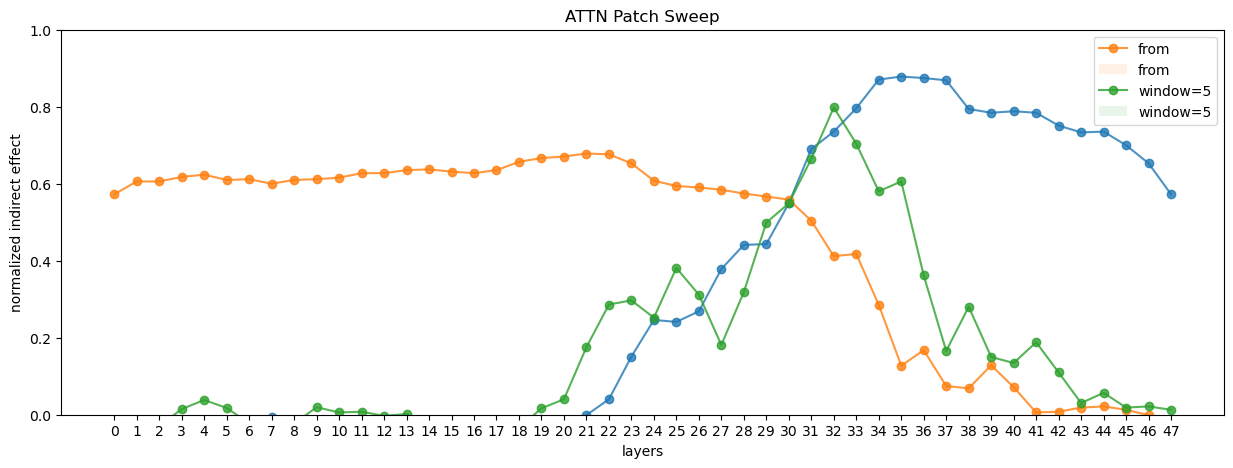

In [81]:
from src.utils.metrics import AggregateMetric

def process_patching_results(
    results: list[dict],
) -> dict[int, AggregateMetric]:

    layers = results[0]["patching_results"].keys()
    layers = sorted(layers)

    layerwise_results = {l: [] for l in layers}
    for sample in results:
        gold_score = sample["gold_score"]
        corrupt_score = sample["corrupt_score"]
        for layer_idx in layers:
            score = sample["patching_results"][layer_idx]["score"]
            layerwise_results[layer_idx].append(
                (score - corrupt_score) / (gold_score - corrupt_score)
            )

    return {l: AggregateMetric.aggregate(v) for l, v in layerwise_results.items()}


from matplotlib import pyplot as plt
import numpy as np

def plot_results(results, canvas, set_canvas_layout = True, label = None):

    layers, values = zip(*results.items())

    means = np.array([v.mean for v in values])
    stds = np.array([v.stdev for v in values])

    canvas.plot(means, marker="o", linewidth=1.5, label = label, alpha = 0.8)
    canvas.fill_between(layers, means - stds, means + stds, alpha=0.1, label = label)

    if set_canvas_layout:
        canvas.ylim(bottom=0, top=1)
        canvas.xticks(layers)
        canvas.title(f"ATTN Patch Sweep")
        canvas.ylabel("normalized indirect effect")
        canvas.xlabel("layers")


plt.figure(figsize=(15, 5))

processed_results_upto = process_patching_results(res_upto)
plot_results(processed_results_upto, plt, set_canvas_layout=True)

processed_results_from = process_patching_results(res_from)
plot_results(processed_results_from, plt, set_canvas_layout=False, label="from" )

processed_results_win = process_patching_results(res_win)
plot_results(processed_results_win, plt, set_canvas_layout=False, label="window=5")

plt.legend()

plt.show()

## What are these heads *looking* back to?

In [18]:
# with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
#     coincidences = json.load(f)

# logger.info(f"{len(coincidences['examples'])=}")

In [19]:
# for idx, entities in enumerate(coincidences["examples"]):
#     print(f"{idx} => {entities['entity_pair']}")

In [20]:
sample_idx = 11
sample = coincidences["examples"][sample_idx]
sample

{'entity_pair': ['crocodile', 'shark'],
 'connection': 'apex predators.',
 'alt_first': {'entity': 'salmon', 'connection': 'fish.'}}

In [21]:
prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)

offset_mapping = prompt.tokenized["offset_mapping"][0]
prompt.tokenized.pop("offset_mapping")

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)

keywords = get_keywords(text = answer, tokenizer=mt)

score, pred, track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    generate_full_ans = True,
    metric = "logit",
)

print(f"{score=}")
print(f"{pred=}")
print(f"{track=}")

" apex predators.
#
Q: The Great Wall of China and the Forbidden City
A: They are"
score=17.375
pred=[PredictedToken(token=' apex', prob=0.255615234375, logit=18.046875, token_id=71527), PredictedToken(token=' predators', prob=0.06768798828125, logit=16.71875, token_id=55117), PredictedToken(token=' top', prob=0.0362548828125, logit=16.09375, token_id=1909), PredictedToken(token=' aquatic', prob=0.0271453857421875, logit=15.8046875, token_id=71391), PredictedToken(token=' considered', prob=0.022857666015625, logit=15.6328125, token_id=6509)]
track={71527: (1, PredictedToken(token=' apex', prob=0.255615234375, logit=18.046875, token_id=71527)), 55117: (2, PredictedToken(token=' predators', prob=0.06768798828125, logit=16.71875, token_id=55117))}


In [22]:
from src.attention import get_attention_matrices

inputs = TokenizerOutput(data=prompt.tokenized)
print(inputs.input_ids.shape)

attn = get_attention_matrices(
    input=inputs,
    mt = mt,
    value_weighted=True
)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([1, 217])
attentions.shape=torch.Size([48, 40, 217, 217]) | values.shape=torch.Size([48, 40, 217, 128])


In [24]:
from src.tokens import find_token_range
from circuitsvis.tokens import colored_tokens
from IPython.display import display, HTML


# LAYERS = list(range(mt.n_layer))
LAYERS = list(range(28, 33))
q_index = -1
remove_bos = True
start_idx = 1 if remove_bos else 0

# start_idx = find_token_range(
#     string=prompt.prompt,
#     substring="#",
#     tokenizer=mt,
#     offset_mapping=offset_mapping,
#     occurrence=-1
# )[1] - 1
print(f"{start_idx=}")

for layer in LAYERS:
    print(f"{layer=}")
    avg_attn_module_matrix = torch.Tensor(attn.attention_matrices[layer]).mean(dim=0)[q_index]

    tokens = [mt.tokenizer.decode(t, skip_special_tokens=False) for t in inputs["input_ids"][0]][start_idx:]
    for idx, t in enumerate(tokens):
        if t == "<think>":
            tokens[idx] = "<|think|>"
        elif t == "</think>":
            tokens[idx] = "<|/think|>"

    display(colored_tokens(
        tokens = tokens,
        values = avg_attn_module_matrix[start_idx:]
    ))
    print("-" * 80)

start_idx=1
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------


In [344]:
LAYER_WINDOW = [29, 30, 31]

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy="ablate_all",
    Q_IDX=-1,
    whitelist_key_indices=[0]
    # whitelist_key_indices=[0, -1]
)

ablated_pred, track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=LAYER_WINDOW,
    # layer_window=[],
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


answer='reptiles.'
[{72627: (12, PredictedToken(token=' apex', prob=0.0166015625, logit=11.390625, token_id=72627))}]


[[PredictedToken(token=' rept', prob=0.08172607421875, logit=12.984375, token_id=64873),
  PredictedToken(token=' pre', prob=0.046539306640625, logit=12.421875, token_id=864),
  PredictedToken(token=' dinosaurs', prob=0.037994384765625, logit=12.21875, token_id=65375),
  PredictedToken(token=' in', prob=0.030059814453125, logit=11.984375, token_id=304),
  PredictedToken(token=' animals', prob=0.0284576416015625, logit=11.9296875, token_id=10099),
  PredictedToken(token=' carniv', prob=0.0263214111328125, logit=11.8515625, token_id=97733),
  PredictedToken(token=' predators', prob=0.0223388671875, logit=11.6875, token_id=56217),
  PredictedToken(token=' top', prob=0.0182342529296875, logit=11.484375, token_id=1948),
  PredictedToken(token=' living', prob=0.0180816650390625, logit=11.4765625, token_id=5496),
  PredictedToken(token=' endangered', prob=0.0175323486328125, logit=11.4453125, token_id=52356),
  PredictedToken(token=' dangerous', prob=0.0175323486328125, logit=11.4453125, toke

In [361]:
inputs = TokenizerOutput(data=prompt.tokenized)

are_range = find_token_range(
    string=prompt.prompt,
    substring="are/were",
    tokenizer=mt,
    offset_mapping=offset_mapping,
    occurrence=-1
)
print(f"{are_range=} | \"{mt.tokenizer.decode(inputs.input_ids[0][slice(*are_range)])}\"")

# block_attention_to = list(range(*are_range))
# block_attention_to += list(range(*prompt.entity_ranges[0])) + list(range(*prompt.entity_ranges[1]))
# block_attention_to += [-1]

# block_attention_to = list(range(start_idx, inputs.input_ids.shape[-1]))
block_attention_to = list(range(1, start_idx))

block_edges: list[AttentionEdge] = []
for k_idx in block_attention_to:
    block_edges.append(
        AttentionEdge(
            q_idx=-1,
            k_idx=k_idx,
        )
    )

ablated_pred, track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=[29, 30, 31],
    # layer_window=[],
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


are_range=(214, 217) | " are/were"
answer='apex predators.'
[{72627: (1, PredictedToken(token=' apex', prob=0.1561279296875, logit=15.796875, token_id=72627))}]


[[PredictedToken(token=' apex', prob=0.1561279296875, logit=15.796875, token_id=72627),
  PredictedToken(token=' pre', prob=0.08160400390625, logit=15.1484375, token_id=864),
  PredictedToken(token=' rept', prob=0.06304931640625, logit=14.890625, token_id=64873),
  PredictedToken(token=' living', prob=0.046142578125, logit=14.578125, token_id=5496),
  PredictedToken(token=' predators', prob=0.0345458984375, logit=14.2890625, token_id=56217),
  PredictedToken(token=' dangerous', prob=0.03271484375, logit=14.234375, token_id=11660),
  PredictedToken(token=' top', prob=0.0264892578125, logit=14.0234375, token_id=1948),
  PredictedToken(token=' animals', prob=0.024688720703125, logit=13.953125, token_id=10099),
  PredictedToken(token=' large', prob=0.0190887451171875, logit=13.6953125, token_id=3544),
  PredictedToken(token=' dinosaurs', prob=0.0179290771484375, logit=13.6328125, token_id=65375),
  PredictedToken(token=' members', prob=0.017791748046875, logit=13.625, token_id=3697),
  Pre

In [362]:
mt.reset_forward()
print(block_edges)
ablate_all_heads_per_layer = {
    h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
}

# attention_contributions = {l: {} for l in LAYER_WINDOW}
attn_matrices = {l: {} for l in LAYER_WINDOW}
for layer_idx in LAYER_WINDOW:
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            cut_attn_edges=ablate_all_heads_per_layer,
            attn_matrices=attn_matrices[layer_idx],
            # attn_contributions=attention_contributions[layer_idx]
        ),
        attn_block
    )

ablated_pred = predict_next_token(
    mt=mt,
    inputs=inputs,
    k=15
)
mt.reset_forward()
ablated_pred

[AttentionEdge(q_idx=-1, k_idx=1), AttentionEdge(q_idx=-1, k_idx=2), AttentionEdge(q_idx=-1, k_idx=3), AttentionEdge(q_idx=-1, k_idx=4), AttentionEdge(q_idx=-1, k_idx=5), AttentionEdge(q_idx=-1, k_idx=6), AttentionEdge(q_idx=-1, k_idx=7), AttentionEdge(q_idx=-1, k_idx=8), AttentionEdge(q_idx=-1, k_idx=9), AttentionEdge(q_idx=-1, k_idx=10), AttentionEdge(q_idx=-1, k_idx=11), AttentionEdge(q_idx=-1, k_idx=12), AttentionEdge(q_idx=-1, k_idx=13), AttentionEdge(q_idx=-1, k_idx=14), AttentionEdge(q_idx=-1, k_idx=15), AttentionEdge(q_idx=-1, k_idx=16), AttentionEdge(q_idx=-1, k_idx=17), AttentionEdge(q_idx=-1, k_idx=18), AttentionEdge(q_idx=-1, k_idx=19), AttentionEdge(q_idx=-1, k_idx=20), AttentionEdge(q_idx=-1, k_idx=21), AttentionEdge(q_idx=-1, k_idx=22), AttentionEdge(q_idx=-1, k_idx=23), AttentionEdge(q_idx=-1, k_idx=24), AttentionEdge(q_idx=-1, k_idx=25), AttentionEdge(q_idx=-1, k_idx=26), AttentionEdge(q_idx=-1, k_idx=27), AttentionEdge(q_idx=-1, k_idx=28), AttentionEdge(q_idx=-1, k_id

[[PredictedToken(token=' apex', prob=0.1561279296875, logit=15.796875, token_id=72627),
  PredictedToken(token=' pre', prob=0.08160400390625, logit=15.1484375, token_id=864),
  PredictedToken(token=' rept', prob=0.06304931640625, logit=14.890625, token_id=64873),
  PredictedToken(token=' living', prob=0.046142578125, logit=14.578125, token_id=5496),
  PredictedToken(token=' predators', prob=0.0345458984375, logit=14.2890625, token_id=56217),
  PredictedToken(token=' dangerous', prob=0.03271484375, logit=14.234375, token_id=11660),
  PredictedToken(token=' top', prob=0.0264892578125, logit=14.0234375, token_id=1948),
  PredictedToken(token=' animals', prob=0.024688720703125, logit=13.953125, token_id=10099),
  PredictedToken(token=' large', prob=0.0190887451171875, logit=13.6953125, token_id=3544),
  PredictedToken(token=' dinosaurs', prob=0.0179290771484375, logit=13.6328125, token_id=65375),
  PredictedToken(token=' members', prob=0.017791748046875, logit=13.625, token_id=3697),
  Pre

In [363]:
for layer in LAYER_WINDOW:
    all_attn_matrices = torch.stack(list(attn_matrices[layer].values()), dim=1)[0]
    avg_attn_matrices = all_attn_matrices.mean(dim=0)[q_index]
    print(avg_attn_matrices.shape)

    tokens = [mt.tokenizer.decode(t, skip_special_tokens=False) for t in inputs["input_ids"][0]][1:]
    # for idx, t in enumerate(tokens):
    #     if t == "<think>":
    #         tokens[idx] = "<|think|>"
    #     elif t == "</think>":
    #         tokens[idx] = "<|/think|>"

    display(colored_tokens(
        tokens = tokens,
        values = avg_attn_matrices[1:]
    ))
    print("-" * 80)

torch.Size([218])


--------------------------------------------------------------------------------
torch.Size([218])


--------------------------------------------------------------------------------
torch.Size([218])


--------------------------------------------------------------------------------


In [365]:
mt.reset_forward()
# attention_contributions = {l: {} for l in LAYER_WINDOW}
attn_matrices = {l: {} for l in LAYER_WINDOW}
for layer_idx in LAYER_WINDOW:
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            # cut_attn_edges=ablate_all_heads_per_layer,
            attn_matrices=attn_matrices[layer_idx],
            # attn_contributions=attention_contributions[layer_idx]
        ),
        attn_block
    )

ablated_pred = predict_next_token(
    mt=mt,
    inputs=inputs,
    k=15
)
mt.reset_forward()
ablated_pred

[[PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627),
  PredictedToken(token=' pre', prob=0.0875244140625, logit=15.296875, token_id=864),
  PredictedToken(token=' rept', prob=0.06158447265625, logit=14.9453125, token_id=64873),
  PredictedToken(token=' living', prob=0.049468994140625, logit=14.7265625, token_id=5496),
  PredictedToken(token=' predators', prob=0.036773681640625, logit=14.4296875, token_id=56217),
  PredictedToken(token=' dangerous', prob=0.03271484375, logit=14.3125, token_id=11660),
  PredictedToken(token=' top', prob=0.02862548828125, logit=14.1796875, token_id=1948),
  PredictedToken(token=' animals', prob=0.024688720703125, logit=14.03125, token_id=10099),
  PredictedToken(token=' dinosaurs', prob=0.020782470703125, logit=13.859375, token_id=65375),
  PredictedToken(token=' large', prob=0.0203094482421875, logit=13.8359375, token_id=3544),
  PredictedToken(token=' considered', prob=0.019378662109375, logit=13.7890625, token_id=6646),

In [368]:
attn_matrices[29][5].shape

torch.Size([1, 218, 218])

In [370]:
for layer in LAYER_WINDOW:
    print(layer)
    for head in range(mt.config.num_attention_heads):
        print(f"{layer=} | {head=}")
        attn_distribution = attn_matrices[layer][head][0][q_index]
        tokens = [mt.tokenizer.decode(t, skip_special_tokens=False) for t in inputs["input_ids"][0]][1:]
        # for idx, t in enumerate(tokens):
        #     if t == "<think>":
        #         tokens[idx] = "<|think|>"
        #     elif t == "</think>":
        #         tokens[idx] = "<|/think|>"

        display(colored_tokens(
            tokens = tokens,
            values = attn_distribution[1:]
        ))
    print("-" * 80)

29
layer=29 | head=0


layer=29 | head=1


layer=29 | head=2


layer=29 | head=3


layer=29 | head=4


layer=29 | head=5


layer=29 | head=6


layer=29 | head=7


layer=29 | head=8


layer=29 | head=9


layer=29 | head=10


layer=29 | head=11


layer=29 | head=12


layer=29 | head=13


layer=29 | head=14


layer=29 | head=15


layer=29 | head=16


layer=29 | head=17


layer=29 | head=18


layer=29 | head=19


layer=29 | head=20


layer=29 | head=21


layer=29 | head=22


layer=29 | head=23


layer=29 | head=24


layer=29 | head=25


layer=29 | head=26


layer=29 | head=27


layer=29 | head=28


layer=29 | head=29


layer=29 | head=30


layer=29 | head=31


--------------------------------------------------------------------------------
30
layer=30 | head=0


layer=30 | head=1


layer=30 | head=2


layer=30 | head=3


layer=30 | head=4


layer=30 | head=5


layer=30 | head=6


layer=30 | head=7


layer=30 | head=8


layer=30 | head=9


layer=30 | head=10


layer=30 | head=11


layer=30 | head=12


layer=30 | head=13


layer=30 | head=14


layer=30 | head=15


layer=30 | head=16


layer=30 | head=17


layer=30 | head=18


layer=30 | head=19


layer=30 | head=20


layer=30 | head=21


layer=30 | head=22


layer=30 | head=23


layer=30 | head=24


layer=30 | head=25


layer=30 | head=26


layer=30 | head=27


layer=30 | head=28


layer=30 | head=29


layer=30 | head=30


layer=30 | head=31


--------------------------------------------------------------------------------
31
layer=31 | head=0


layer=31 | head=1


layer=31 | head=2


layer=31 | head=3


layer=31 | head=4


layer=31 | head=5


layer=31 | head=6


layer=31 | head=7


layer=31 | head=8


layer=31 | head=9


layer=31 | head=10


layer=31 | head=11


layer=31 | head=12


layer=31 | head=13


layer=31 | head=14


layer=31 | head=15


layer=31 | head=16


layer=31 | head=17


layer=31 | head=18


layer=31 | head=19


layer=31 | head=20


layer=31 | head=21


layer=31 | head=22


layer=31 | head=23


layer=31 | head=24


layer=31 | head=25


layer=31 | head=26


layer=31 | head=27


layer=31 | head=28


layer=31 | head=29


layer=31 | head=30


layer=31 | head=31


--------------------------------------------------------------------------------
